## <span style="background-color:red;color:white;">ESTÁ OBSOLETO, en prueba_02 cambio el densifier a OneHotEncoder ajustando un parámetro que permite compatibilidad con el modelo HistGradientBoostingRegressor</span>

### OJO 👁️👁️
con la base de CHATGPT >>
 comparar metodología con el curso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import FunctionTransformer


In [2]:

# 1. Carga de datos
completo = pd.read_csv('transform_listings.csv')
df = completo[['neighbourhood_group_cleansed','bedrooms', 'bathrooms', 'price']]



In [ ]:
# 2.1 No hago preprocesado porque ya lo hice en el notebook de transform_listings

# más adelante filtro precios outliers para mejorar los resultados de los modelos

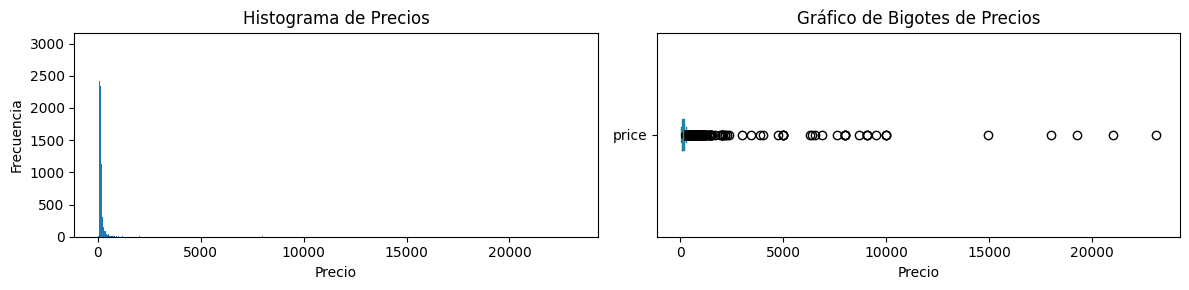

In [3]:
# Histogramay bigotes sin quitar outliers

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
df['price'].plot(kind='hist', ax=axes[0], bins=1000)
# df['price'].plot(kind='hist', ax=axes[0], bins=int(np.sqrt(len(df['price']))))
axes[0].set_title('Histograma de Precios')
axes[0].set_xlabel('Precio')
axes[0].set_ylabel('Frecuencia')
df['price'].plot(kind='box', ax=axes[1], vert=False)
axes[1].set_title('Gráfico de Bigotes de Precios')
axes[1].set_xlabel('Precio')
plt.tight_layout()
plt.show()

In [4]:
# # # # Filtro los outliers utilizando el rango intercuartílico (IQR): 
# # # ¿Mejoraría algo con z-score?
Q1  = df['price'].quantile(0.25)
Q3  = df['price'].quantile(0.75)
IQR = Q3 - Q1
IQR
df = df[(df['price']>=Q1 - 1.5 * IQR) & (df['price']<=Q3 + 1.5 * IQR)]

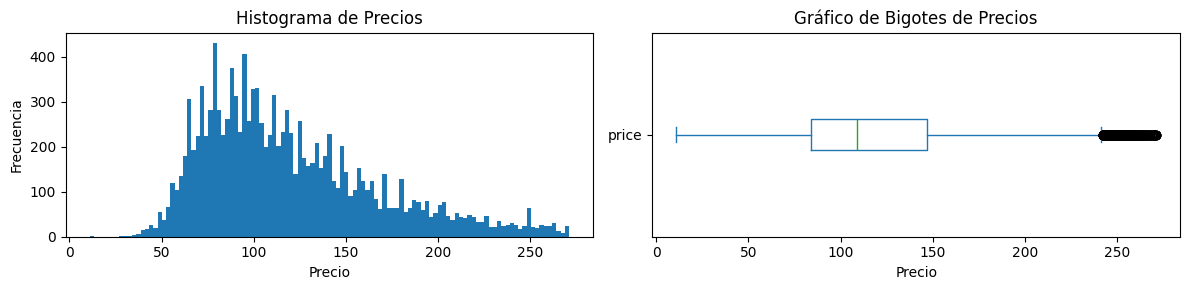

In [5]:
# Histograma y bigotes con outliers quitados (método IQR)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
df['price'].plot(kind='hist', ax=axes[0], bins=int(np.sqrt(len(df['price']))))
axes[0].set_title('Histograma de Precios')
axes[0].set_xlabel('Precio')
axes[0].set_ylabel('Frecuencia')
df['price'].plot(kind='box', ax=axes[1], vert=False)
axes[1].set_title('Gráfico de Bigotes de Precios')
axes[1].set_xlabel('Precio')
plt.tight_layout()
plt.show()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12856 entries, 0 to 13870
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   12856 non-null  int64  
 1   listing_url                   12856 non-null  object 
 2   name                          12856 non-null  object 
 3   description                   12541 non-null  object 
 4   neighbourhood_cleansed        12856 non-null  object 
 5   neighbourhood_group_cleansed  12856 non-null  object 
 6   latitude                      12856 non-null  float64
 7   longitude                     12856 non-null  float64
 8   property_type                 12856 non-null  object 
 9   room_type                     12856 non-null  object 
 10  accommodates                  12856 non-null  int64  
 11  bathrooms                     12856 non-null  int64  
 12  bedrooms                      12856 non-null  int64  
 13  amenit

In [6]:
densifier = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)

# 1. Carga y limpieza
df = df.dropna(subset=['bedrooms','bathrooms','neighbourhood_group_cleansed','price'])

# 2. Separar X/y
X = df[['bedrooms','bathrooms','neighbourhood_group_cleansed']]
y = df['price']

# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 4. Preprocesador: escala numéricos + one-hot para distrito
numeric_feats = ['bedrooms','bathrooms']
cat_feats     = ['neighbourhood_group_cleansed']

preprocessor = ColumnTransformer([
    ('num',   StandardScaler(),    numeric_feats),
    ('cat',   OneHotEncoder(drop='first'), cat_feats),
])

# 5. Definir pipelines para cada modelo
models = {
    'LinearRegression': Pipeline([('prep', preprocessor),
                                  ('reg',  LinearRegression())]),
    'Ridge':            Pipeline([('prep', preprocessor),
                                  ('reg',  Ridge(alpha=1.0, random_state=42))]),
    'Lasso':            Pipeline([('prep', preprocessor),
                                  ('reg',  Lasso(alpha=0.1, random_state=42))]),
    'ElasticNet':       Pipeline([('prep', preprocessor),
                                  ('reg',  ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))]),
    'KNeighbors':       Pipeline([('prep', preprocessor),
                                  ('reg',  KNeighborsRegressor(n_neighbors=5))]),
    'SVR':              Pipeline([('prep', preprocessor),
                                  ('reg',  SVR(kernel='rbf', C=1.0))]),
    'RandomForest':     Pipeline([('prep', preprocessor),
                                  ('reg',  RandomForestRegressor(n_estimators=100, random_state=42))]),
    'GradientBoosting': Pipeline([('prep', preprocessor),
                                  ('reg',  GradientBoostingRegressor(
                                      n_estimators=100, learning_rate=0.1, 
                                      max_depth=3, random_state=42))]),
    'ExtraTrees': Pipeline([('prep', preprocessor),
                            ('reg', ExtraTreesRegressor(n_estimators=100, random_state=42))]),
    'AdaBoost': Pipeline([('prep', preprocessor),
                          ('reg', AdaBoostRegressor(n_estimators=100, random_state=42))]),
    'HistGradientBoosting': Pipeline([('prep', preprocessor),
                                      ('densify',densifier),
                                      ('reg', HistGradientBoostingRegressor(max_iter=100, random_state=42))]),
    'MLPRegressor': Pipeline([('prep', preprocessor),
                              ('reg', MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42))]),
}

# 6. Definir métricas para cross_validate
scoring = {
    'MAE':   'neg_mean_absolute_error',
    'RMSE':  'neg_root_mean_squared_error',
    'R2':    'r2',
    'MAPE':  'neg_mean_absolute_percentage_error',
    'EVS':   'explained_variance',
}

# 7. Ejecutar validación cruzada en train
results = {}
for name, pipe in models.items():
    cv = cross_validate(pipe, X_train, y_train,
                        cv=5, scoring=scoring,
                        return_train_score=False)
    # invertir signos de las métricas negativas
    mae_mean  = -cv['test_MAE'].mean()
    rmse_mean = -cv['test_RMSE'].mean()
    mape_mean = -cv['test_MAPE'].mean()
    results[name] = {
        'MAE':  mae_mean,
        'RMSE': rmse_mean,
        'R2':   cv['test_R2'].mean(),
        'MAPE': mape_mean,
        'EVS':  cv['test_EVS'].mean(),
    }

# 8. Mostrar comparativa ordenada por MAE
results_df = pd.DataFrame(results).T.sort_values('MAE')
display(results_df.round(3))


,MAE,RMSE,R2,MAPE,EVS
HistGradientBoosting,28.684,37.793,0.372,0.265,0.372
MLPRegressor,28.780,37.853,0.370,0.266,0.371
RandomForest,28.793,37.982,0.365,0.266,0.366
ExtraTrees,28.828,38.067,0.362,0.266,0.363
GradientBoosting,28.879,37.947,0.367,0.268,0.367
SVR,29.001,39.072,0.328,0.253,0.347
Ridge,29.094,38.268,0.356,0.269,0.356
LinearRegression,29.096,38.268,0.356,0.269,0.356
Lasso,29.257,38.375,0.352,0.271,0.353
ElasticNet,29.726,38.740,0.340,0.277,0.340


He visto esto respecto a métricas:
https://medium.com/@nicolasarrioja/m%C3%A9tricas-en-regresi%C3%B3n-5e5d4259430b
